In [2]:
import numpy as np
import torch
import torchvision.transforms.functional as F
from torch import nn

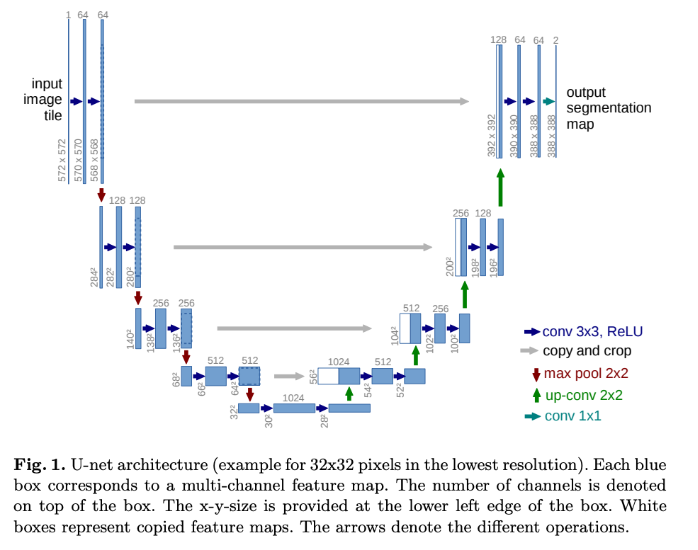

In [5]:
class DoubleConvolution(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.act1 = nn.ReLU()
    self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    self.act2 = nn.ReLU()

  def forward(self, x):
    x = self.first(x)
    x = self.act1(x)
    x = self.second(x)
    x = self.act2(x)
    return x

class DownSample(nn.Module):
  def __init__(self):
    super().__init__()
    self.pool = nn.MaxPool2d(kernel_size=2)

  def forward(self, x):
    return self.pool(x)

class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

  def forward(self, x):
    return self.up(x)

class CropAndConcat(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x, contracting_x):
    contracting_x = F.center_crop(contracting_x, x.shape[2], x.shape[3])
    x = torch.cat([x, contracting_x], dim=1)
    return x

In [6]:
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in \
     [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
    self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
    self.middle_conv = DoubleConvolution(512, 1024)
    self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in \
     [(1024, 512), (512, 256), (256, 128), (128, 64)]])
    self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in\
                                  [(1024, 512), (512, 256), (256, 128), (128, 64)]])
    self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
    self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

  def forward(self, x):
    pass_through = []
    for i in range(len(self.down_conv)):
      x = self.down_conv[i](x)
      pass_through.append(x)
      x = self.down_sample[i](x)
    x = self.middle_conv(x)
    for i in range(len(self.up_conv)):
      x = self.up_sample[i](x)
      x = self.concat[i](x, pass_through.pop())
      x = self.up_conv[i](x)
    x = self.final_conv(x)
    return x

Mounted at /content/drive
